In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
# map measurement class 
Mea =Base.classes.measurement
# map station class
sta =Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session= Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types
columns = inspector.get_columns('Mea')
for c in columns:
    print(c['name'], c["type"])
# columns

# Exploratory Climate Analysis

one year ago:  2016-08-23


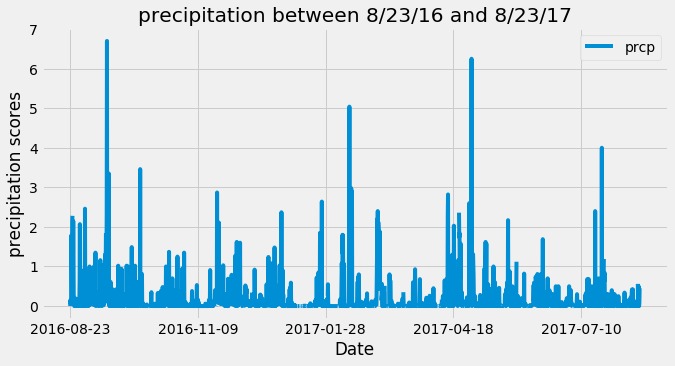

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_precipitation_date= session.query(Mea.date).order_by(Mea.date.desc()).first()

List_lastPrcp=session.query(Mea.date).\
    filter(Mea.date >= '2016-08-23').\
    order_by(Mea.date).all()

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017,8, 23) - dt.timedelta(days=365)
print("one year ago: ", query_date)
# Perform a query to retrieve the data and precipitation scores
result=session.query(Mea.date,Mea.prcp).\
    filter(Mea.date>= '2016-08-23').\
    order_by(Mea.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
data= pd.DataFrame(result, columns=["date", "prcp"])
# Sort the dataframe by date
data= data.set_index('date').sort_index(ascending= True)

# Use Pandas Plotting with Matplotlib to plot the data
ax= data.plot(title="precipitation between 8/23/16 and 8/23/17",figsize=(10,5 ))
ax.set_xlabel("Date")
ax.set_ylabel("precipitation scores")
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_data= data.describe()
summary_data

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
Number_stations= session.query(sta).count()
print(f"there are {Number_stations} stations available")

there are 9 stations available


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
MostRows_sta= session.query(Mea.station, func.count(Mea.station)).group_by(Mea.station).order_by(func.count(Mea.station).desc()).all()
MostRows_sta
#station id of the most active station
station_id=MostRows_sta[0][0]
#retrieve name of the station
Name_MostRows_sta= (session.query(sta.name).filter(sta.station==station_id)).all()

Name_small=Name_MostRows_sta[0][0][:7]
MostRows_sta

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#lowest temperature recorded
lowest_temp= session.query(Mea.station, func.min(Mea.tobs)).filter(Mea.station==station_id).all()
# highest temperature recorded
highest_temp= session.query(Mea.station, func.max(Mea.tobs)).filter(Mea.station==station_id).all()
#average temperature of the most active statio
AVG_MostRow_Act= session.query(func.avg(Mea.tobs)).filter(Mea.station==station_id).all()
AVG_MostRow_Act='{:.3}'.format(AVG_MostRow_Act[0][0])
print(f'The lowest temperature of the most active station is {lowest_temp}')
print(f'The highest temperature of the most active station is {highest_temp}')
print(f'Average temperature of the most active station is {AVG_MostRow_Act}')

The lowest temperature of the most active station is [('USC00519281', 54.0)]
The highest temperature of the most active station is [('USC00519281', 85.0)]
Average temperature of the most active station is 71.7


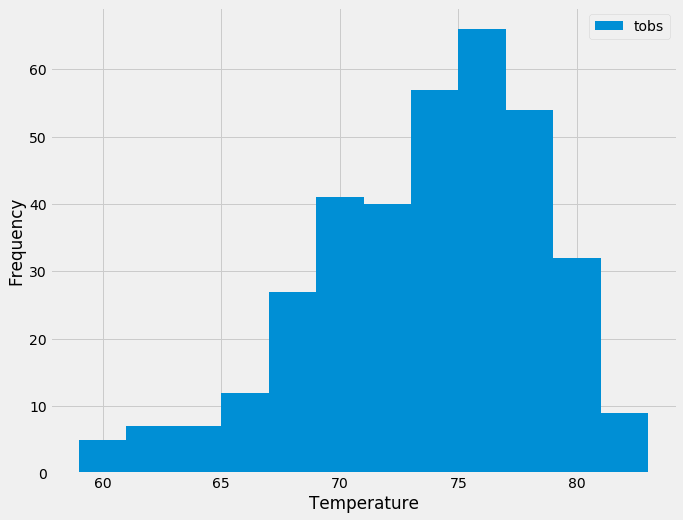

In [20]:
# Choose the station with the highest number of temperature observations.
Name_MostRows_sta= (session.query(sta.name).filter(sta.station==station_id)).all()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#query for dates and find latest
Final_date = session.query(Mea.date).filter(Mea.station==station_id).order_by(Mea.date.desc()).first()
#extract string from query object
Final_date = list(np.ravel(Final_date ))[0]
#convert  string to a datetime object
Final_date = dt.datetime.strptime(Final_date, '%Y-%m-%d')
#extract year, month, and day and convert to integers
Year = int(dt.datetime.strftime(Final_date, '%Y'))
Month = int(dt.datetime.strftime(Final_date, '%m'))
Day = int(dt.datetime.strftime(Final_date, '%d'))
# the date 12 Months Priors
A_yearPrior_date = dt.date(Year,Month,Day) - dt.timedelta(days=365)
# List of the last 12 months of temperature observation data
station_select= session.query( Mea.date, Mea.tobs).filter(Mea.station==station_id, Mea.date>= A_yearPrior_date).order_by(Mea.date.asc()).all()

#convert to pandas DataFrame 
converted_df= pd.DataFrame(station_select)
# set and sort index by date
converted_df.set_index('date')
converted_df.sort_index(ascending=True)
converted_df.plot(kind='hist', figsize=(10,8), bins=12)
plt.xlabel("Temperature")
plt.show()

In [29]:
sel = [Mea.date, func.min(Mea.tobs), func.avg(Mea.tobs), func.max(Mea.tobs)]

results =  (session.query(*sel).group_by(Mea.date).all())
results

[('2010-01-01', 65.0, 69.71428571428571, 75.0),
 ('2010-01-02', 61.0, 67.0, 75.0),
 ('2010-01-03', 67.0, 74.0, 77.0),
 ('2010-01-04', 72.0, 75.0, 76.0),
 ('2010-01-05', 73.0, 74.5, 76.0),
 ('2010-01-06', 71.0, 73.33333333333333, 76.0),
 ('2010-01-07', 68.0, 70.42857142857143, 74.0),
 ('2010-01-08', 63.0, 65.57142857142857, 73.0),
 ('2010-01-09', 67.0, 68.57142857142857, 70.0),
 ('2010-01-10', 70.0, 72.71428571428571, 75.0),
 ('2010-01-11', 64.0, 66.71428571428571, 72.0),
 ('2010-01-12', 57.0, 61.57142857142857, 68.0),
 ('2010-01-13', 57.0, 61.5, 68.0),
 ('2010-01-14', 65.0, 66.42857142857143, 69.0),
 ('2010-01-15', 56.0, 64.83333333333333, 69.0),
 ('2010-01-16', 65.0, 67.33333333333333, 71.0),
 ('2010-01-17', 64.0, 68.0, 70.0),
 ('2010-01-18', 70.0, 73.0, 77.0),
 ('2010-01-19', 61.0, 69.42857142857143, 75.0),
 ('2010-01-20', 66.0, 67.85714285714286, 72.0),
 ('2010-01-21', 68.0, 69.5, 71.0),
 ('2010-01-22', 60.0, 63.5, 67.0),
 ('2010-01-23', 67.0, 73.83333333333333, 78.0),
 ('2010-01-24

## Bonus Challenge Assignment

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Mea.tobs), func.avg(Mea.tobs), func.max(Mea.tobs)).\
        filter(Mea.date >= start_date).filter(Mea.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip='2017-01-01 to 2018-01-01'
trip_int= calc_temps('2017-05-28', '2017-06-04')
trip_int

[(71.0, 77.26086956521739, 82.0)]

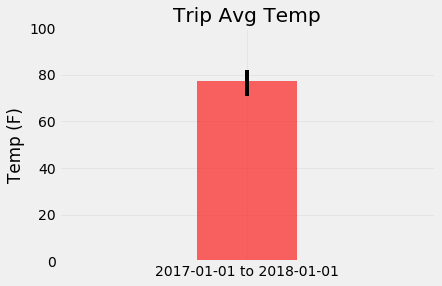

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
minTemp = trip_int[0][0]
avgTemp = trip_int[0][1]
maxTemp = trip_int[0][2]

minError = avgTemp - minTemp
maxError = maxTemp - avgTemp

error_int = np.array([[minError], [maxError]])

plt.bar(trip, avgTemp, yerr=error_int, color = 'red', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
